# Importing necessary libraries

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Importing datasets

In [76]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [77]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [78]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

# Model Architecture

In [79]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, image):
        x = self.conv1(image)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Training without federated learning

## Training setup

In [80]:
model = Classifier().to(device)

In [81]:
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [83]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training

In [84]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss / len(dataloader)

In [85]:
train_loss_history = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    train_loss_history.append(train_loss)
    
    print(f"[Epoch: {epoch+1}/{num_epochs}] - [Loss: {train_loss}]")

[Epoch: 1/10] - [Loss: 2.2985458330790203]
[Epoch: 2/10] - [Loss: 2.245207355117798]
[Epoch: 3/10] - [Loss: 2.0029785041809083]
[Epoch: 4/10] - [Loss: 1.4791467666943867]
[Epoch: 5/10] - [Loss: 1.0613666116396585]
[Epoch: 6/10] - [Loss: 0.8394960426012675]
[Epoch: 7/10] - [Loss: 0.7120330683390299]
[Epoch: 8/10] - [Loss: 0.6221629185199737]
[Epoch: 9/10] - [Loss: 0.5549947983423869]
[Epoch: 10/10] - [Loss: 0.5048095518747966]


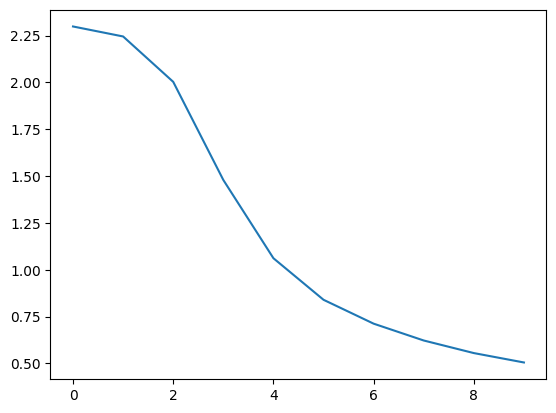

In [86]:
plt.plot(train_loss_history)
plt.show()

## Evaluation

In [87]:
def evaluate(model, dataloader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
        return test_loss / len(dataloader)

In [88]:
test_loss = evaluate(model, test_loader)
print(test_loss)

0.21953799961783443


In [89]:
# Accuracy
preds = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs, 1)[1]
    preds.extend(predicted.cpu().numpy())
preds = torch.Tensor(preds)

accuracy = sum(preds == test_dataset.targets) / len(test_dataset.targets) * 100
accuracy

tensor(93.8300)

# Partitioning dataset for heterogeneity

In [90]:
indices = (train_dataset.targets == 0) | (train_dataset.targets == 1)
train_dataset_device1 = torch.utils.data.Subset(train_dataset, torch.where(indices == True)[0])

indices = (train_dataset.targets == 2) | (train_dataset.targets == 3)
train_dataset_device2 = torch.utils.data.Subset(train_dataset, torch.where(indices == True)[0])

indices = (train_dataset.targets == 4) | (train_dataset.targets == 5)
train_dataset_device3 = torch.utils.data.Subset(train_dataset, torch.where(indices == True)[0])

indices = (train_dataset.targets == 6) | (train_dataset.targets == 7)
train_dataset_device4 = torch.utils.data.Subset(train_dataset, torch.where(indices == True)[0])

indices = (train_dataset.targets == 8) | (train_dataset.targets == 9)
train_dataset_device5 = torch.utils.data.Subset(train_dataset, torch.where(indices == True)[0])

In [91]:
train_loader_device1 = torch.utils.data.DataLoader(train_dataset_device1, batch_size=32, shuffle=True)
train_loader_device2 = torch.utils.data.DataLoader(train_dataset_device2, batch_size=32, shuffle=True)
train_loader_device3 = torch.utils.data.DataLoader(train_dataset_device3, batch_size=32, shuffle=True)
train_loader_device4 = torch.utils.data.DataLoader(train_dataset_device4, batch_size=32, shuffle=True)
train_loader_device5 = torch.utils.data.DataLoader(train_dataset_device5, batch_size=32, shuffle=True)

# FedAvg

## Training setup for 5 devices

In [92]:
com_rounds = 15
learning_rate = 0.001
batch_size = 32
num_epochs = 5
num_clients = 5

In [93]:
model = Classifier().to(device) # This model will be passed to all devices which will update weights according to the training data.

model_device1 = Classifier().to(device)
model_device2 = Classifier().to(device)
model_device3 = Classifier().to(device)
model_device4 = Classifier().to(device)
model_device5 = Classifier().to(device)

In [94]:
criterion = nn.CrossEntropyLoss()

## Training

In [95]:
train_loader_client = [train_loader_device1, train_loader_device2, train_loader_device3, train_loader_device4, train_loader_device5]
model_client = [model_device1, model_device2, model_device3, model_device4, model_device5]
train_loss_history_fedavg = []
for com_round in range(com_rounds):
    print(f"Starting Communication round {com_round+1}")
    total_loss = 0
    model_state_dict = model.state_dict()
    
    for client in range(num_clients):
        model_client[client].load_state_dict(model_state_dict)
        optimizer_device = torch.optim.SGD(model_client[client].parameters(), lr=learning_rate)
        
        # Training model at device.
        print(f"Training model at Device {client+1}")
        for epoch in range(num_epochs):
            train_loss = train(model_client[client], train_loader_client[client], criterion, optimizer_device)
            total_loss += train_loss / num_epochs
            print(f"[Epoch: {epoch+1}/{num_epochs}] - [Loss: {train_loss}]")
            
    train_loss_history_fedavg.append(total_loss / num_clients)
        
    # Averaging (weighted) the model paramters for final model according to the number of datapoints in each device.
    state_dicts = [model_device.state_dict() for model_device in model_client]
    size_train_datasets = [len(train_dataset_device1), len(train_dataset_device2), len(train_dataset_device3), len(train_dataset_device4), len(train_dataset_device5)]
    keys = model_state_dict.keys()
    state_dict_averaged = {}
    for key in keys:
        state_dict_averaged[key] = sum((size_train_datasets[i]/len(train_dataset)) * state_dict[key] for i, state_dict in enumerate(state_dicts))

    model.load_state_dict(state_dict_averaged)
    print()

Starting Communication round 1
Training model at Device 1
[Epoch: 1/5] - [Loss: 1.54811410485494]
[Epoch: 2/5] - [Loss: 0.5865983313532791]
[Epoch: 3/5] - [Loss: 0.29346621222794056]
[Epoch: 4/5] - [Loss: 0.15977876644694444]
[Epoch: 5/5] - [Loss: 0.10859241491804521]
Training model at Device 2
[Epoch: 1/5] - [Loss: 1.623913128697683]
[Epoch: 2/5] - [Loss: 0.7910032250263073]
[Epoch: 3/5] - [Loss: 0.6383099692366111]
[Epoch: 4/5] - [Loss: 0.5031313108546394]
[Epoch: 5/5] - [Loss: 0.379739170233724]
Training model at Device 3
[Epoch: 1/5] - [Loss: 1.759198852222074]
[Epoch: 2/5] - [Loss: 0.8345877506177534]
[Epoch: 3/5] - [Loss: 0.6882550557228652]
[Epoch: 4/5] - [Loss: 0.5809308904307809]
[Epoch: 5/5] - [Loss: 0.4637011700225147]
Training model at Device 4
[Epoch: 1/5] - [Loss: 1.5582632114255208]
[Epoch: 2/5] - [Loss: 0.70514028607391]
[Epoch: 3/5] - [Loss: 0.4338140581536481]
[Epoch: 4/5] - [Loss: 0.26231935549908736]
[Epoch: 5/5] - [Loss: 0.17090988509220087]
Training model at Devic

## Evaluation

In [96]:
test_loss = evaluate(model, test_loader)
print(test_loss)

0.782524905646571


In [97]:
# Accuracy
preds = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs, 1)[1]
    preds.extend(predicted.cpu().numpy())
preds = torch.Tensor(preds)

accuracy = sum(preds == test_dataset.targets) / len(test_dataset.targets) * 100
accuracy

tensor(74.9400)

In [98]:
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    output_labels = torch.argmax(outputs, axis=1)
    print(output_labels)
    break

tensor([7, 8, 1, 0, 4, 1, 9, 9, 2, 9, 0, 2, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 4, 5,
        9, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')


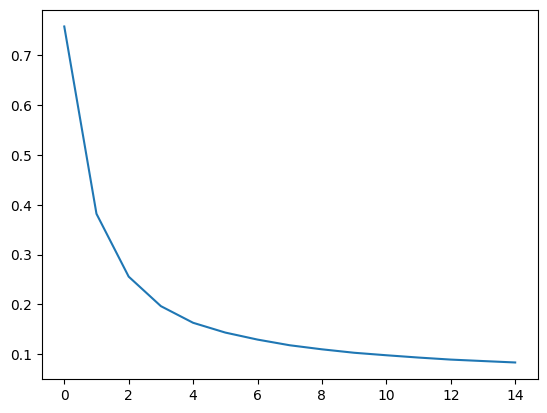

In [99]:
plt.plot(train_loss_history_fedavg)
plt.show()

# FedOpt

## Training setup for 5 devices

In [100]:
com_rounds = 15
learning_rate = 0.001
batch_size = 32
num_epochs = 5
num_clients = 5

In [101]:
model = Classifier().to(device) # This model will be passed to all devices which will update weights according to the training data.

model_device1 = Classifier().to(device)
model_device2 = Classifier().to(device)
model_device3 = Classifier().to(device)
model_device4 = Classifier().to(device)
model_device5 = Classifier().to(device)

In [102]:
criterion = nn.CrossEntropyLoss()

## Training

In [103]:
train_loader_client = [train_loader_device1, train_loader_device2, train_loader_device3, train_loader_device4, train_loader_device5]
model_client = [model_device1, model_device2, model_device3, model_device4, model_device5]

train_loss_history_fedavg = []
for com_round in range(com_rounds):
    print(f"Starting Communication round {com_round+1}")
    total_loss = 0
    model_state_dict = model.state_dict()
    
    for client in range(num_clients):
        model_client[client].load_state_dict(model_state_dict)
        optimizer_device = torch.optim.SGD(model_client[client].parameters(), lr=learning_rate)
        
        # Training model at device.
        print(f"Training model at Device {client+1}")
        for epoch in range(num_epochs):
            train_loss = train(model_client[client], train_loader_client[client], criterion, optimizer_device)
            total_loss += train_loss / num_epochs
            print(f"[Epoch: {epoch+1}/{num_epochs}] - [Loss: {train_loss}]")
            
    train_loss_history_fedavg.append(total_loss / num_clients)
        
    # Averaging (weighted) the model paramters and model gradients for final model according to the number of datapoints in each device.
    state_dicts = [model_device.state_dict() for model_device in model_client]
    size_train_datasets = [len(train_dataset_device1), len(train_dataset_device2), len(train_dataset_device3), len(train_dataset_device4), len(train_dataset_device5)]
    keys = model_state_dict.keys()
    temp_state_dict = model.state_dict()
    for key in keys:
        model_state_dict[key].fill_(0.)
        for i, state_dict in enumerate(state_dicts):
            model_state_dict[key] += (size_train_datasets[i]/len(train_dataset)) * state_dict[key]
            
            if i == 0:
                model_state_dict[key].grad = (state_dict[key] - temp_state_dict[key]) * size_train_datasets[i]/len(train_dataset)
            else:
                model_state_dict[key].grad += (state_dict[key] - temp_state_dict[key]) * size_train_datasets[i]/len(train_dataset)
        
    model.load_state_dict(model_state_dict)
    print()

Starting Communication round 1
Training model at Device 1
[Epoch: 1/5] - [Loss: 1.50627325144079]
[Epoch: 2/5] - [Loss: 0.506479529870881]
[Epoch: 3/5] - [Loss: 0.21559330358198195]
[Epoch: 4/5] - [Loss: 0.11498158406748464]
[Epoch: 5/5] - [Loss: 0.08096132189919701]
Training model at Device 2
[Epoch: 1/5] - [Loss: 1.5439569395055215]
[Epoch: 2/5] - [Loss: 0.8265258923724845]
[Epoch: 3/5] - [Loss: 0.6890358254707679]
[Epoch: 4/5] - [Loss: 0.5684441553537177]
[Epoch: 5/5] - [Loss: 0.44505952267104354]
Training model at Device 3
[Epoch: 1/5] - [Loss: 1.76089359074831]
[Epoch: 2/5] - [Loss: 0.8713377179069952]
[Epoch: 3/5] - [Loss: 0.738001677122983]
[Epoch: 4/5] - [Loss: 0.6808829260143366]
[Epoch: 5/5] - [Loss: 0.6072653626853769]
Training model at Device 4
[Epoch: 1/5] - [Loss: 1.7572684874684792]
[Epoch: 2/5] - [Loss: 0.8038540144604961]
[Epoch: 3/5] - [Loss: 0.5604417443744779]
[Epoch: 4/5] - [Loss: 0.3640788373515362]
[Epoch: 5/5] - [Loss: 0.21967485472755482]
Training model at Devi

## Evaluation

In [104]:
test_loss = evaluate(model, test_loader)
print(test_loss)

0.6653557083667657


In [105]:
# Accuracy
preds = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs, 1)[1]
    preds.extend(predicted.cpu().numpy())
preds = torch.Tensor(preds)

accuracy = sum(preds == test_dataset.targets) / len(test_dataset.targets) * 100
accuracy

tensor(79.2100)

In [106]:
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    output_labels = torch.argmax(outputs, axis=1)
    print(output_labels)
    break

tensor([7, 2, 1, 0, 4, 1, 7, 9, 2, 9, 0, 6, 9, 0, 1, 5, 9, 7, 6, 9, 7, 6, 6, 5,
        9, 0, 7, 9, 0, 1, 3, 1], device='cuda:0')


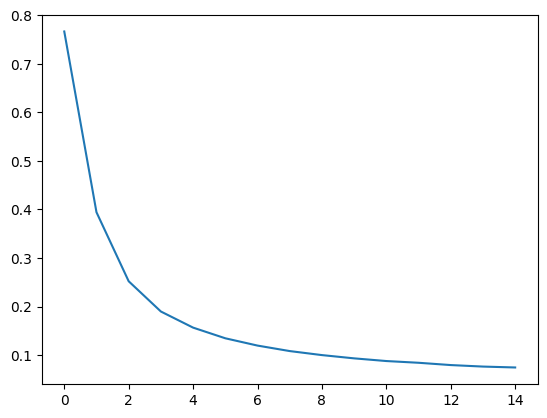

In [107]:
plt.plot(train_loss_history_fedavg)
plt.show()

# FedProx

## Training setup for 5 devices

In [108]:
com_rounds = 15
learning_rate = 0.001
batch_size = 32
num_epochs = 5
num_clients = 5
mu = 0.01  # Regularization parameter for FedProx

In [109]:
model = Classifier().to(device) # This model will be passed to all devices which will update weights according to the training data.

model_device1 = Classifier().to(device)
model_device2 = Classifier().to(device)
model_device3 = Classifier().to(device)
model_device4 = Classifier().to(device)
model_device5 = Classifier().to(device)

In [110]:
criterion = nn.CrossEntropyLoss()

## Training

In [111]:
# Modifying the train function to include regularization term.
def train(model, dataloader, criterion, optimizer, mu, server):
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        for param1, param2 in zip(model.parameters(), server.parameters()):
            loss += (mu / 2) * torch.norm((param1.data - param2.data), p=2)**2
        
        optimizer.zero_grad()
        loss.backward()
        
        for param in model.parameters():
            param.grad += mu * torch.rand_like(param.grad)
        
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss / len(dataloader)

In [112]:
train_loader_client = [train_loader_device1, train_loader_device2, train_loader_device3, train_loader_device4, train_loader_device5]
model_client = [model_device1, model_device2, model_device3, model_device4, model_device5]

train_loss_history_fedavg = []
for com_round in range(com_rounds):
    print(f"Starting Communication round {com_round+1}")
    total_loss = 0
    model_state_dict = model.state_dict()
    
    for client in range(num_clients):
        model_client[client].load_state_dict(model_state_dict)
        optimizer_device = torch.optim.SGD(model_client[client].parameters(), lr=learning_rate)
        
        # Training model at device.
        print(f"Training model at Device {client+1}")
        for epoch in range(num_epochs):
            train_loss = train(model_client[client], train_loader_client[client], criterion, optimizer_device, mu, model)
            total_loss += train_loss / num_epochs
            print(f"[Epoch: {epoch+1}/{num_epochs}] - [Loss: {train_loss}]")
            
    train_loss_history_fedavg.append(total_loss / num_clients)
        
    # Averaging (weighted) the model paramters and model gradients for final model according to the number of datapoints in each device.
    state_dicts = [model_device.state_dict() for model_device in model_client]
    size_train_datasets = [len(train_dataset_device1), len(train_dataset_device2), len(train_dataset_device3), len(train_dataset_device4), len(train_dataset_device5)]
    keys = model_state_dict.keys()
    temp_state_dict = model.state_dict()
    for key in keys:
        model_state_dict[key].fill_(0.)
        for i, state_dict in enumerate(state_dicts):
            model_state_dict[key] += (size_train_datasets[i]/len(train_dataset)) * state_dict[key]
            
            if i == 0:
                model_state_dict[key].grad = (state_dict[key] - temp_state_dict[key]) * size_train_datasets[i]/len(train_dataset)
            else:
                model_state_dict[key].grad += (state_dict[key] - temp_state_dict[key]) * size_train_datasets[i]/len(train_dataset)
        
    model.load_state_dict(model_state_dict)
    print()

Starting Communication round 1
Training model at Device 1
[Epoch: 1/5] - [Loss: 1.3385833536434655]
[Epoch: 2/5] - [Loss: 0.6364630076921347]
[Epoch: 3/5] - [Loss: 0.40225257145033944]
[Epoch: 4/5] - [Loss: 0.2569456785315215]
[Epoch: 5/5] - [Loss: 0.20076401258884657]
Training model at Device 2
[Epoch: 1/5] - [Loss: 1.4553975940696777]
[Epoch: 2/5] - [Loss: 0.8220077551231182]
[Epoch: 3/5] - [Loss: 0.7445585719807438]
[Epoch: 4/5] - [Loss: 0.691557903138418]
[Epoch: 5/5] - [Loss: 0.6145813558152113]
Training model at Device 3
[Epoch: 1/5] - [Loss: 2.06919465823607]
[Epoch: 2/5] - [Loss: 1.0363089614971117]
[Epoch: 3/5] - [Loss: 0.752871888097037]
[Epoch: 4/5] - [Loss: 0.6352148243988102]
[Epoch: 5/5] - [Loss: 0.5387641908600926]
Training model at Device 4
[Epoch: 1/5] - [Loss: 1.870344559038718]
[Epoch: 2/5] - [Loss: 0.9105160266082744]
[Epoch: 3/5] - [Loss: 0.5925061161436747]
[Epoch: 4/5] - [Loss: 0.3894358134958062]
[Epoch: 5/5] - [Loss: 0.2851607206612434]
Training model at Device

## Evaluation

In [113]:
test_loss = evaluate(model, test_loader)
print(test_loss)

1.3291555391713834


In [114]:
# Accuracy
preds = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs, 1)[1]
    preds.extend(predicted.cpu().numpy())
preds = torch.Tensor(preds)

accuracy = sum(preds == test_dataset.targets) / len(test_dataset.targets) * 100
accuracy

tensor(53.4000)

In [115]:
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    output_labels = torch.argmax(outputs, axis=1)
    print(output_labels)
    break

tensor([7, 5, 5, 0, 9, 1, 7, 7, 2, 7, 0, 6, 9, 0, 7, 5, 9, 7, 6, 4, 7, 6, 4, 5,
        4, 0, 7, 9, 0, 3, 3, 7], device='cuda:0')


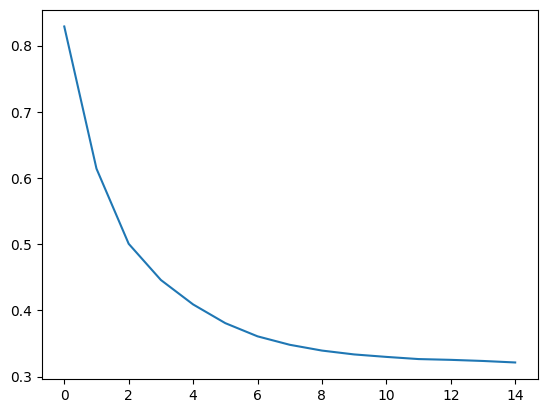

In [116]:
plt.plot(train_loss_history_fedavg)
plt.show()